In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import qmc
from scipy.stats import norm

Create Brownian Bridges

In [4]:
def create_BB(mc_runs, d, delta_t):
    h = d                       #h : Differenz der Punkte in Indexpunkten
    X = np.empty((mc_runs,d+1))       #+1 damit die 0 am Anfang mit dabei ist
    X[:,0] = 0
    X[:,d] = np.sqrt(d * delta_t) * np.random.randn(mc_runs)
    for i in range(k):
        h = int(h/2)
        pos = h
        for j in range(2**i):
            X[:,pos] = (1/2) * X[:,pos - h] + (1/2) * X[:,pos + h] + np.sqrt((1/2) * h * delta_t) * np.random.randn(mc_runs)
            #print(pos)
            pos = pos + 2*h
    return X

Create Standard Brownian Motion

In [5]:
def create_standard_bm(mc_runs, d, delta_t):
    #create lower trinangular matrix with ones
    BM = np.empty([mc_runs,d])
    for i in range(mc_runs):
        lower_tri_matr = np.tril(np.ones([d,d]))
        A = math.sqrt(delta_t)*lower_tri_matr
        #create Brownian motion
        BM[i,:] = A.dot(np.random.normal(0,1,d))

    return BM

Create Asset prices

In [12]:
def create_asset_prices(BB, mc_runs, d, delta_t, S_0, mu, sigma):
    S = np.empty([mc_runs, d+1]) #+1 weil d mal simuliert wird und aber der Startpreis des Assets auch in dem Vektor steht
    
    S[:,0] = S_0

    if BB == True:
        BM = create_BB(mc_runs, d, delta_t)
        BM = BM[:,1:len(BM)] #um B_0 abzuschneiden
    else:
        BM = create_standard_bm(mc_runs, d, delta_t)  #w_0 ist nciht dabei aber interessiert mich auch nicht

    for k in range(mc_runs):
        for i in range(d):
            S[k, i+1] = S[k, 0]*np.exp(sigma*BM[k, i] + (mu-(sigma**2)/2)*(i+1)*delta_t)
    return S
    

Calculate Payoff

In [7]:
def ratched_option(BB, mc_runs, d, delta_t, S_0, mu, sigma): 
    S = create_asset_prices(BB, mc_runs, d, delta_t, S_0, mu, sigma)

    indic = np.diff(S)>0

    payoff = (indic*S[:,1:S.size]).mean(axis=1)  #python spezifisch fehlt dann das erste Element

    plt.plot(S.T)
    plt.title("Simulation of "+str(mc_runs)+" sample paths of Asset Prices ")
    plt.show()
    return payoff

# Monte Carlo Simulation

set parameters

In [8]:
T = 1
k = 3
d = 2**k
delta_t = T/d

S_0 = 100
mu = 0.045
sigma = 0.3

mc_runs = 1000


Exaktes Ergebnis

In [9]:
Exp = (S_0/d)*norm.cdf((mu-((sigma**2)/2))*math.sqrt(delta_t)/sigma+sigma*math.sqrt(delta_t))*np.sum(np.exp(mu*delta_t*(np.array(range(d))+1)))
display(Exp)

55.618171509982446

Monte Carlo Simulation mit Standard BM und Brownian Bridges

Fehlerberechnung RMSE in Option paper ist es aber irgendwie relativ (weil so nicht wirklich vergleichbar mit verschiedenen Längen der Option)

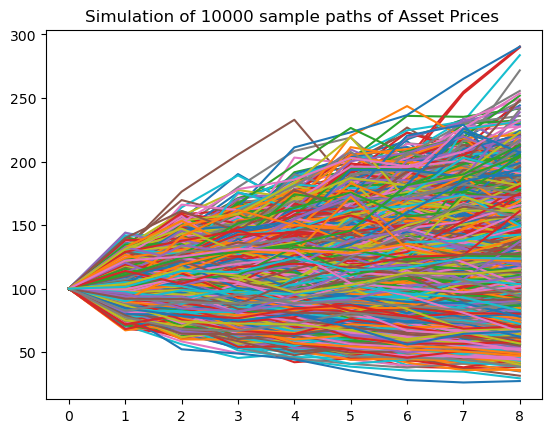

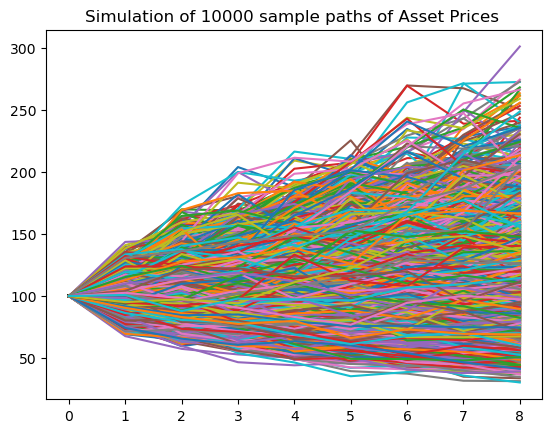

In [18]:
n = np.linspace(10,10000, 1000, dtype = int)
mc_sim_SBM = np.empty(len(n))
mc_sim_BB = np.empty(len(n))

mc_runs = int(n[len(n)-1])

BB = False
payoff_SBM = ratched_option(BB, mc_runs, d, delta_t, S_0, mu, sigma)

BB = True
payoff_BB = ratched_option(BB, mc_runs, d, delta_t, S_0, mu, sigma)

#Darf ich die Simulation so machen, in dem ich ich immer ein Teilintervall nehme?
for i in range(len(n)):
    mc_sim_SBM[i] = payoff_SBM[:n[i]].mean() #Hier werden aus Payoff MC Wert berechnet
    mc_sim_BB[i] = payoff_BB[:n[i]].mean()


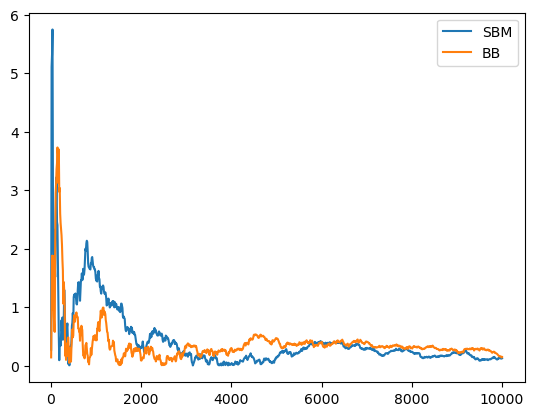

In [19]:
plt.plot(n, np.sqrt((mc_sim_SBM - Exp)**2), label = 'SBM')
plt.plot(n, np.sqrt((mc_sim_BB - Exp)**2), label = 'BB')
plt.legend()
plt.show()